# Predicting Knowledge Level Using User Knowledge Data

A user knowledge model is a model that tries to build up a conceptual understanding of its users. In the context of a learning environment, this means that a learning system can adapt to how a certain user is learning new concepts based on their individual learning ability. As such, having a well-built user knowledge model is invaluable in creating adaptive, online learning environments. 

We are using a user knowledge modeling data set collected by Hamdi Tolga Kahraman to answer the following question:

**How high will somebody’s knowledge score be based on their study time, exam performance, and prerequisite knowledge?**

The data set contains 405 observations from on subjects who both prepared for and took an exam on Electrical DC Machines. The subjects prepared for and took two exams: one on prerequisite material, and one on targeted material whose knowledge built upon the prerequisite material. It includes columns for the degree of study time for both prerequisite knowledge and new knowledge bases, exam performances for both prerequisite knowledge and new knowledge bases, the degree of repetition, and the user’s knowledge level. The user knowledge level column has four categories: very low, low, middle, and high. We found no information on the age group or educational background of the participants.  


All columns are recognized as type double except for the level of the user’s knowledge (which is a character variable). The data appears to be already normalized because all values (other than the user’s knowledge level) fit between values of 0 and 1. The data is very close to being tidy - other than a description of the data in an extra column, the literal data itself is tidy. 

## **TODO** Preliminary Data Exploration


for justifications: 
- justify why we chose the predictors we did (maybe we just wanted to focus on time spent studying, to isolate one variable?)
- use chapter 6 predictor selection

Let's begin by analyzing our data. First, of course, we must load the libraries and set our seed. 

In [5]:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
library(GGally)
set.seed(1)

Then, we'll read our dataset from the web. This includes cleaning and wrangling it into a tidy format. To clean and wrangle it, we need to unselect the two empty columns and the column with the description of the data, rename the columns and mutate our classification label to a factor data type.

In [6]:
downloaded_data <- download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", 
                                "knowledge.xls")

user_knowledge_data <- read_excel("knowledge.xls", 
                                  sheet = 2) %>%  #data we want is on page 2 of the excel file
    select(-"...7", -"...8", -"Attribute Information:")  # unselect unnecessary columns

# rename columns
colnames(user_knowledge_data) <- c("targeted_study_time", 
                                   "repetition", 
                                   "prereq_study_time", 
                                   "prereq_exam_performance", 
                                   "targeted_exam_performance", 
                                   "understanding_level")

# change class label to factor 
user_knowledge_data <- user_knowledge_data %>%
    mutate(understanding_level = as_factor(understanding_level)) 

head(user_knowledge_data)

New names:
* `` -> ...7
* `` -> ...8



targeted_study_time,repetition,prereq_study_time,prereq_exam_performance,targeted_exam_performance,understanding_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


Now that we've cleaned and wrangled our data, we can split it between a testing and training set. We'll put the testing set aside for now.

In [67]:
knowledge_split <- initial_split(user_knowledge_data, prop = .75, strata = understanding_level)
knowledge_train <- training(knowledge_split)
knowledge_test <- testing(knowledge_split)
fail() # how do we justfiy prop value?

ERROR: Error in fail(): could not find function "fail"


Next, we can summarize the training data in informative tables. We'll include the following tables:
- means, max, min of each predictor
- how many of each label exist in the data frame

In [8]:
knowledge_train_means <- knowledge_train %>%
    summarize(target_study_time_mean = mean(targeted_study_time),
          repetition_mean = mean(repetition),
          prereq_study_time_mean = mean(prereq_study_time),
          prereq_exam_performance_mean = mean(prereq_exam_performance),
          targeted_exam_performance_mean = mean(targeted_exam_performance)) 
knowledge_train_means

target_study_time_mean,repetition_mean,prereq_study_time_mean,prereq_exam_performance_mean,targeted_exam_performance_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3750154,0.3527385,0.4640769,0.4234872,0.4546821


Let's discuss the `mean` table. We can see above that the participants who participated in the study generally spent less time studying for their targeted material (i.e. electrical DC machines) than they did on their prerequisite materials (unspecified topic). Furthermore, we can see that the means for the prerequisite and targeted exam performances are incredibly similar, but the targeted exam performance is slightly higher. This is as expected, since we would suspect that after participants studied for the targeted exam performance with the prequisite knowledge under their belts, they would perform better.

In [9]:
knowledge_train_max <- knowledge_train %>% 
    summarize(target_study_time_max = max(targeted_study_time),
          repetition_max = max(repetition),
          prereq_study_time_max = max(prereq_study_time),
          prereq_exam_performance_max = max(prereq_exam_performance),
          targeted_exam_performance_max = max(targeted_exam_performance)) 
knowledge_train_max

knowledge_train_min <- knowledge_train %>%
    summarize(target_study_time_min = min(targeted_study_time),
          repetition_min = min(repetition),
          prereq_study_time_min = min(prereq_study_time),
          prereq_exam_performance_min = min(prereq_exam_performance),
          targeted_exam_performance_min = min(targeted_exam_performance)) 
knowledge_train_min

target_study_time_max,repetition_max,prereq_study_time_max,prereq_exam_performance_max,targeted_exam_performance_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.99,0.9,0.95,0.99,0.93


target_study_time_min,repetition_min,prereq_study_time_min,prereq_exam_performance_min,targeted_exam_performance_min
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0


Now let's discuss the min and max values. These are fairly self explanatory, and confirm that some of the participants indeed had very high or very low levels of understanding.

In [10]:
knowledge_labels <- knowledge_train %>%
group_by(understanding_level) %>%
    summarize(count = n())
knowledge_labels

`summarise()` ungrouping output (override with `.groups` argument)



understanding_level,count
<fct>,<int>
very_low,20
High,47
Low,62
Middle,66


Finally, let's discuss the amount of observations in each category. We can see that there are much fewer participants who scored very low, and roughly equal amounts who scored low and middle. There is also a slightly smaller amount of participants who scored high. Knowing the distributions of these categories will help us choose an appropriate number of k values to try. We don't want to have our K value be more than double our smallest category (`very_low`) - otherwise, our smallest category will never have enough "voting power".  

Now that we've examined our data, let's observe the trends between our predictor variables with some plots. Specifically, we want to compare each of our predictors to each other and note how distinct the clusters of `understanding_level` are. The tighter the clusters and the more separated they are, the easier it will be for our KNN model to predict the correct label - so the more useful those predictors will be in our final model. So the strength of the cluster 'tightness', coupled with forward selection, will help us determine which predictors we want to use in our final model.

ERROR: Error in fail(): could not find function "fail"


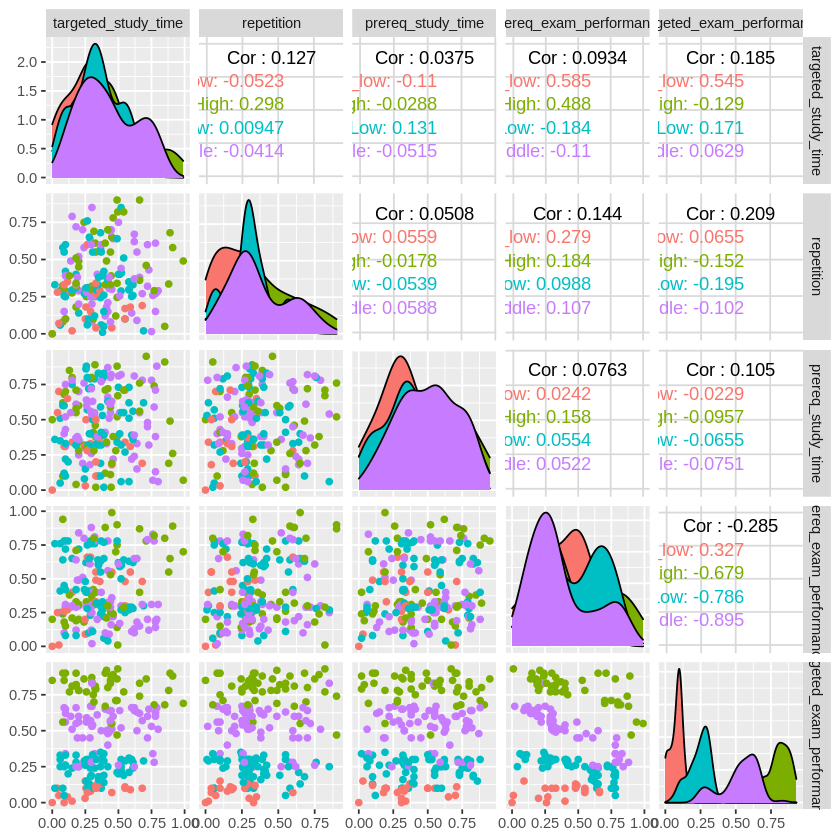

In [11]:
pairs <- knowledge_train %>%
    ggpairs(columns = 1:5, mapping=ggplot2::aes(colour = understanding_level)) +
        theme(legend.position = "bottom")

pairs
fail() # how do we add a legend?

From this visualization, we can see that `targeted_exam_performance` is a predictor we definitely want to include in our model, since all other predictors, when compaerd with it, produce tightly clustered groups of `understanding_level`s. Furthermore, we can see that `prereq_exam_performance` and `targeted_exam_performance` form the tightest clustering, although the other predictors coupled with `targeted_exam_performance` work well to separate the groups also. Before doing our forward selection, we can settle on including roughly all of our predictors when building our model. 

# ***Forward Selection***


### ****Step 1****
To begin our forward selection process, we will first create a tibble to store our results.

In [60]:
set.seed(1)
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>


### ****Step 2****
Since we will use the same specification all time, it is good that we create at the beginning.

In [61]:
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

### ****Step 3****
Now we should create a 10-vold cross-validation object

In [62]:
set.seed(1)
user_vfold <- vfold_cv(knowledge_train, v = 10, strata = understanding_level)

### ****Step 4****
Since we do not have forward selection in R, we need to prepare several things. First we get the names of all the potential predictors, and also store the total number of predictors.

In [63]:
names <- colnames(knowledge_train %>% select(-understanding_level))

In [64]:
n_total <- length(names)

We should also store the selected predictors.

In [65]:
selected <- c()

### ****Step 5****
Now let us perform the forward selection:

In [66]:
set.seed(1)
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("understanding_level", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        user_recipe <- recipe(as.formula(model_string), 
                              data = knowledge_train) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(user_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = user_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,understanding_level ~ targeted_exam_performance,0.8524896
2,understanding_level ~ targeted_exam_performance+prereq_exam_performance,0.9596032
3,understanding_level ~ targeted_exam_performance+prereq_exam_performance+repetition,0.9384670
4,understanding_level ~ targeted_exam_performance+prereq_exam_performance+repetition+targeted_study_time,0.8767502
5,understanding_level ~ targeted_exam_performance+prereq_exam_performance+repetition+targeted_study_time+prereq_study_time,0.7860109


### ****Conclusion of Choosing Predictors****
By comparing the accuracies, we can conclude that we should use targeted exam performance and prerequisite exam performance as our predictors, which has the highest accuracy.

## **Predicative Scenarios**

Now that we have fully analyzed our data, we can consider a couple of predicative scenarios. 

Firstly, from our classification model we expect to find that students with higher prerequisite knowledge and exam score will be classified as having a higher knowledge level. To visualize the results of our model, we can use a confusion matrix to analyze the amount of observations that were predicted correctly. More importantly, we can discuss whether a higher false prediction (i.e. predicting an incorrect `high` knowledge level for a `low` observation) or a lower false prediction (i.e. predicting an incorrect `low` knowledge level for a `high` observation) is more impactful or "incorrect". 
    
    
Secondly, these findings could highlight the importance of having a solid foundation of basic knowledge prior to learning more complex materials, and describe how the amount of time studied influences one’s knowledge level. 
    
    
And lastly, there are a couple of future questions that our analysis could lead to, such as "what factors determine/influence exam performance?" and "what other study methods, other than amount of time studied, can influence exam performance?". 